In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_df = pd.read_csv('../../data/processed/fully_integrated_data.csv')
data_df.columns

Index(['raceId', 'season', 'raceNumber', 'circuitId', 'prixName', 'raceDate',
       'driverId', 'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorName', 'constructorNationality',
       'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins', 'constructorRacePoints',
       'driverDateOfBirth', 'driverNationality',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry', 'lat', 'lng', 'alt',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'race_time'],
      dtype='object')

In [ ]:
def max_consecutive(series):
    streak = 0
    max_streak = 0
    for val in series:
        if val:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

In [27]:
df_finished = data_df[data_df["driverRaceResultStatus"] == "Finished"]
driver_consistency = df_finished.groupby("driverId").agg(
    driverName=('driverName', 'first'),
    total_races=('raceId', 'count'),
    avg_finish=('driverFinalRank', 'mean'),
    std_finish=('driverFinalRank', 'std'),
    median_finish=('driverFinalRank', 'median'),
    top3_count=('driverFinalRank', lambda x: (x <= 3).sum()),
    avg_points=('driverRacePoints', 'mean'),
    points_std=('driverRacePoints', 'std'),
    total_points=('driverRacePoints', 'sum'),
    
    # Position-based metrics
    wins=('driverFinalRank', lambda x: (x == 1).sum()),
    win_rate=('driverFinalRank', lambda x: (x == 1).sum() / len(x)),
    top5_count=('driverFinalRank', lambda x: (x <= 5).sum()),
    top10_count=('driverFinalRank', lambda x: (x <= 10).sum()),
    
    # Streak metrics
    longest_top3_streak=('driverFinalRank', lambda x: max_consecutive(x <= 3)),
    longest_points_streak=('driverFinalRank', lambda x: max_consecutive(x <= 10)),
    
    # Performance variation
    position_range=('driverFinalRank', lambda x: x.max() - x.min()),
    quartile_deviation=('driverFinalRank', lambda x: x.quantile(0.75) - x.quantile(0.25))
).reset_index()


driver_consistency["top3_rate"] = driver_consistency["top3_count"] / driver_consistency["total_races"]
driver_consistency['points_consistency'] = 1 / driver_consistency['points_std'].replace(0, pd.NA)

driver_consistency["consistency_score"] = 1 / driver_consistency["std_finish"].replace(0, pd.NA)

driver_consistency.shape

(331, 21)

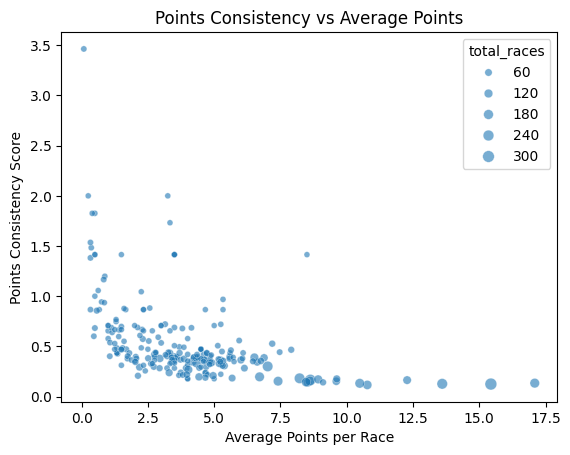

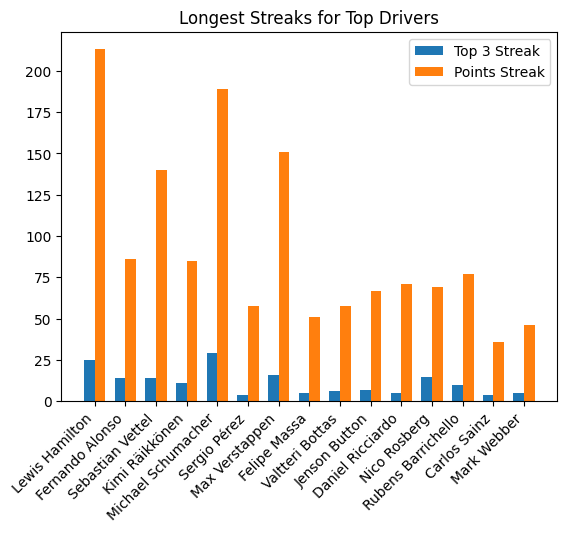

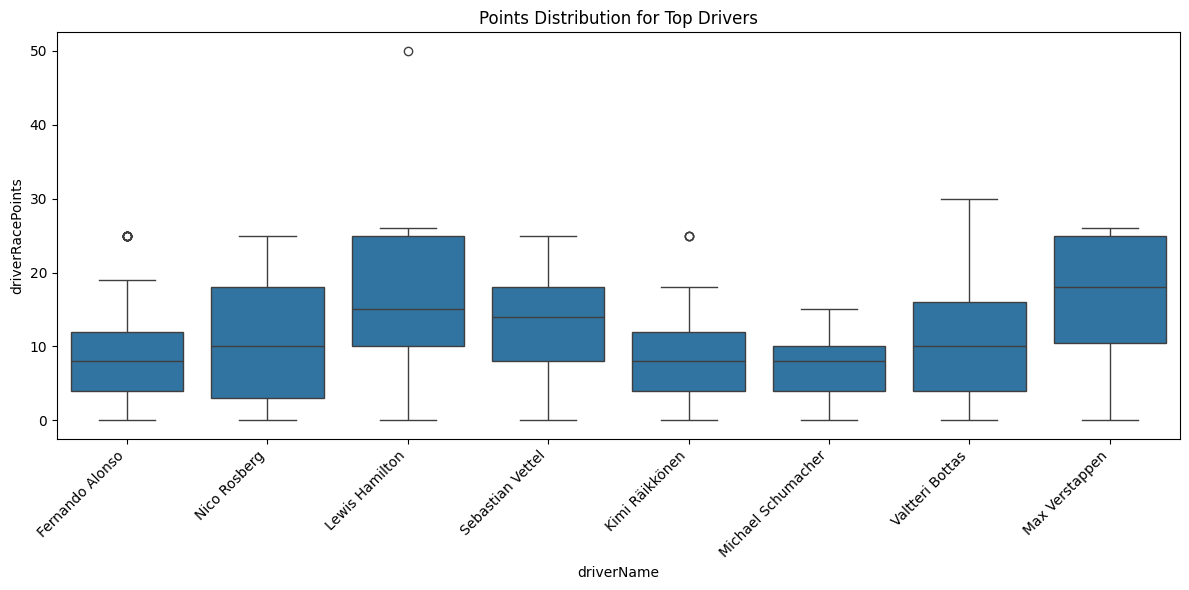

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.scatterplot(data=driver_consistency, 
                x='avg_points', 
                y='points_consistency',
                size='total_races',
                alpha=0.6)
plt.title('Points Consistency vs Average Points')
plt.xlabel('Average Points per Race')
plt.ylabel('Points Consistency Score')
plt.show()


top_drivers = driver_consistency.nlargest(15, 'total_races')
bar_width = 0.35
x = np.arange(len(top_drivers))
plt.bar(x - bar_width/2, top_drivers['longest_top3_streak'], 
        bar_width, label='Top 3 Streak')
plt.bar(x + bar_width/2, top_drivers['longest_points_streak'], 
        bar_width, label='Points Streak')
plt.xticks(x, top_drivers['driverName'], rotation=45, ha='right')
plt.title('Longest Streaks for Top Drivers')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
top_drivers = driver_consistency.nlargest(8, 'total_points')
sns.boxplot(data=df_finished[df_finished['driverName'].isin(top_drivers['driverName'])],
            x='driverName',
            y='driverRacePoints')
plt.title('Points Distribution for Top Drivers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

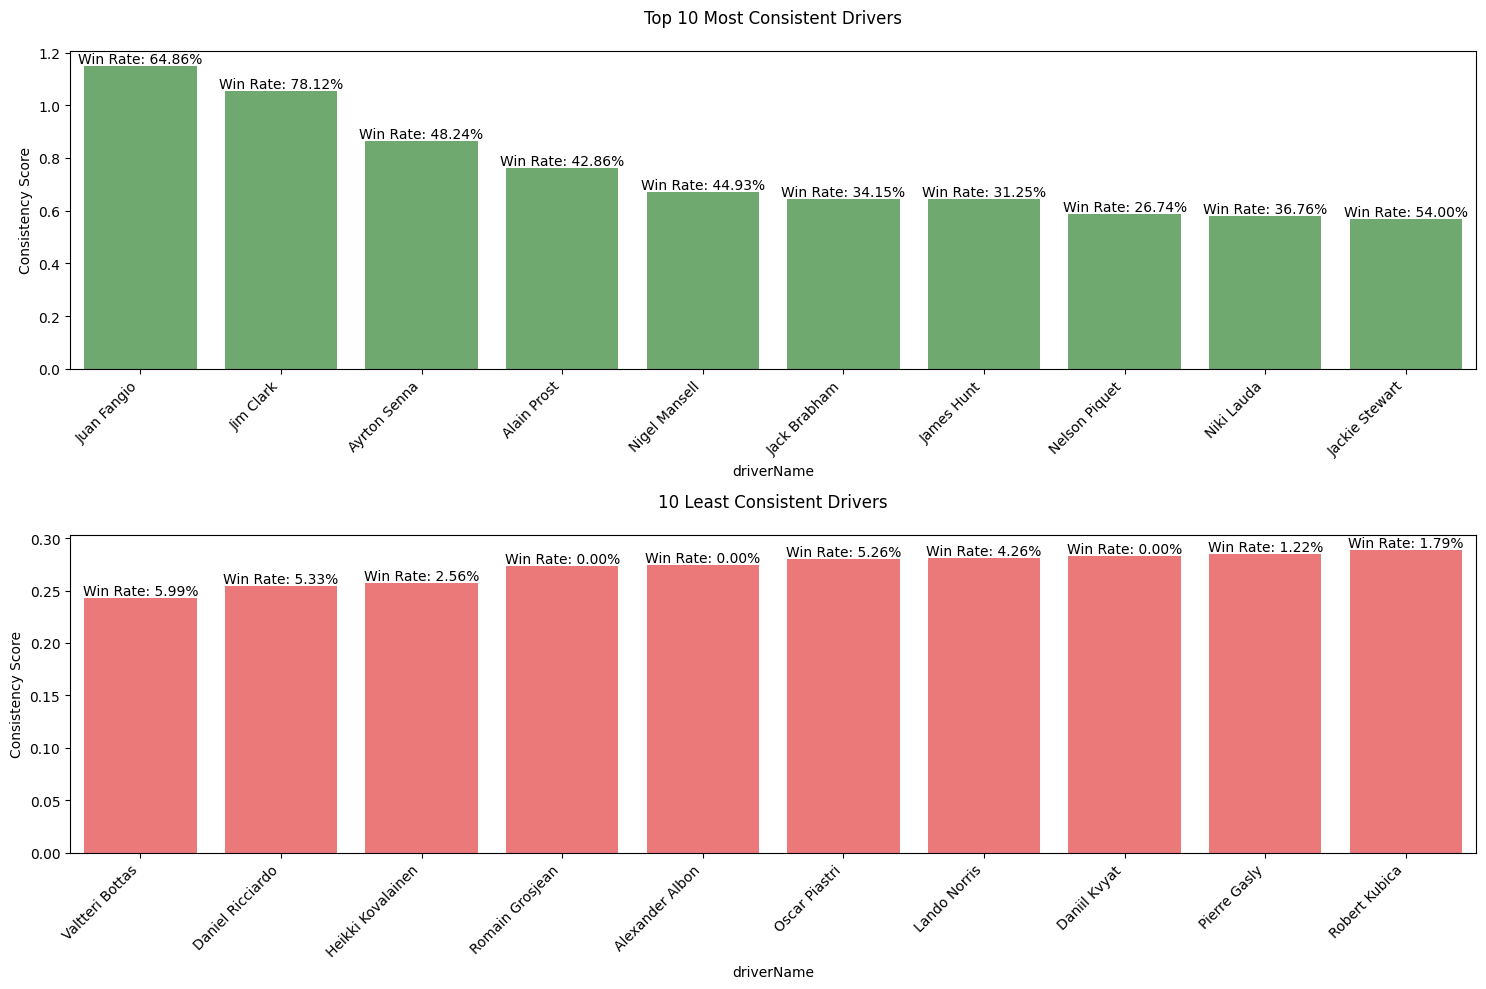

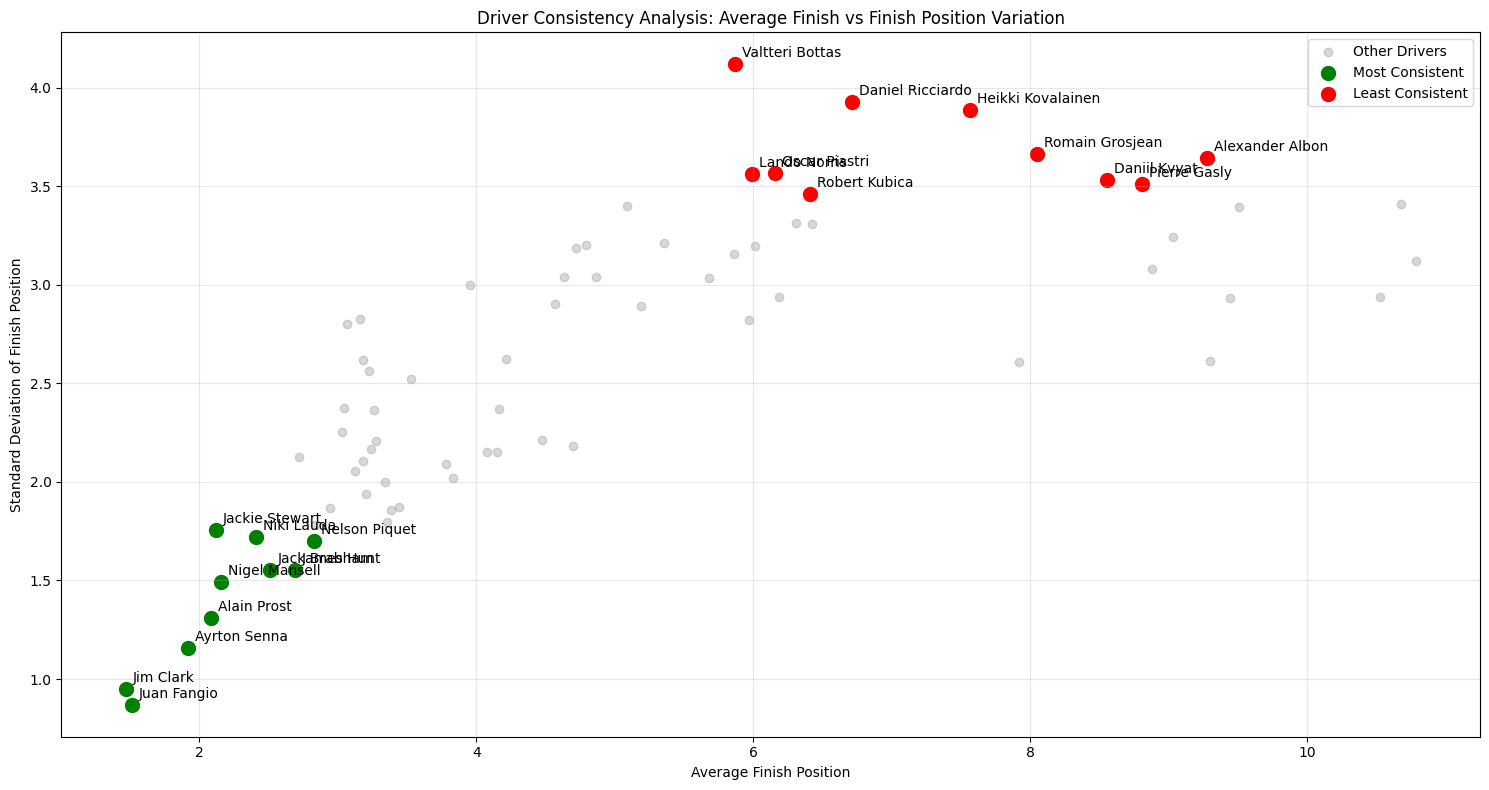

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

min_races = 30
driver_consistency['consistency_score'] = pd.to_numeric(driver_consistency['consistency_score'], errors='coerce')

filtered_drivers = driver_consistency[driver_consistency['total_races'] >= min_races]

top_10_consistent = filtered_drivers.nlargest(10, 'consistency_score')
bottom_10_consistent = filtered_drivers.nsmallest(10, 'consistency_score')

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

sns.barplot(data=top_10_consistent,
            x='driverName',
            y='consistency_score',
            color='green',
            alpha=0.6)

plt.title('Top 10 Most Consistent Drivers', fontsize=12, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Consistency Score')

for i, row in enumerate(top_10_consistent.itertuples()):
    plt.text(i, row.consistency_score, 
             f'Win Rate: {row.win_rate:.2%}',
             ha='center', va='bottom')

# Plot for least consistent drivers
plt.subplot(2, 1, 2)
sns.barplot(data=bottom_10_consistent,
            x='driverName',
            y='consistency_score',
            color='red',
            alpha=0.6)

plt.title('10 Least Consistent Drivers', fontsize=12, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Consistency Score')

# Add win rate as text on bars
for i, row in enumerate(bottom_10_consistent.itertuples()):
    plt.text(i, row.consistency_score, 
             f'Win Rate: {row.win_rate:.2%}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional visualization comparing performance metrics
plt.figure(figsize=(15, 8))

# Create scatter plot for all drivers
plt.scatter(filtered_drivers['avg_finish'], 
           filtered_drivers['std_finish'],
           alpha=0.3,
           color='grey',
           label='Other Drivers')

# Highlight top 10 consistent drivers
plt.scatter(top_10_consistent['avg_finish'],
           top_10_consistent['std_finish'],
           color='green',
           s=100,
           label='Most Consistent')

# Highlight bottom 10 consistent drivers
plt.scatter(bottom_10_consistent['avg_finish'],
           bottom_10_consistent['std_finish'],
           color='red',
           s=100,
           label='Least Consistent')

plt.xlabel('Average Finish Position')
plt.ylabel('Standard Deviation of Finish Position')
plt.title('Driver Consistency Analysis: Average Finish vs Finish Position Variation')
plt.legend()

for idx, row in top_10_consistent.iterrows():
    plt.annotate(row['driverName'], 
                (row['avg_finish'], row['std_finish']),
                xytext=(5, 5), textcoords='offset points')
    
for idx, row in bottom_10_consistent.iterrows():
    plt.annotate(row['driverName'], 
                (row['avg_finish'], row['std_finish']),
                xytext=(5, 5), textcoords='offset points')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Insights 

### Driver Consistency Analysis

1. **Points Consistency vs Average Points:**
    - The scatter plot shows a positive correlation between average points per race and points consistency score.
    - Drivers with higher average points tend to have more consistent performance, as indicated by the points consistency score.

2. **Longest Streaks for Top Drivers:**
    - The bar plot highlights the longest top 3 and points streaks for the top drivers based on the total number of races.
    - Some drivers exhibit remarkable consistency by maintaining long streaks of top 3 finishes or scoring points in consecutive races.

3. **Points Distribution for Top Drivers:**
    - The box plot provides a visual representation of the points distribution for the top drivers.
    - It shows the variability in points scored by each driver, with some drivers having a more consistent points distribution than others.

4. **Top 10 Most Consistent Drivers:**
    - The bar plot identifies the top 10 most consistent drivers based on their consistency score.
    - These drivers have lower standard deviations in their finish positions, indicating stable performance across races.
    - Win rates are displayed on each bar, showing that consistent drivers often have higher win rates.

5. **10 Least Consistent Drivers:**
    - The bar plot highlights the 10 least consistent drivers, who have higher variability in their finish positions.
    - These drivers may have more fluctuating performance, with some races being significantly better or worse than others.
    - Win rates are also displayed, indicating that less consistent drivers tend to have lower win rates.

6. **Driver Consistency Analysis: Average Finish vs Finish Position Variation:**
    - The scatter plot shows the relationship between average finish position and the standard deviation of finish positions.
    - Most consistent drivers (green dots) tend to have lower average finish positions and lower standard deviations, indicating stable and high performance.
    - Least consistent drivers (red dots) have higher average finish positions and higher standard deviations, indicating more variable performance.
    - Grey dots represent other drivers, providing a context for comparison.

### Inference

- Consistency is a key factor in driver performance, with more consistent drivers generally achieving better results and higher win rates.
- Drivers who can maintain long streaks of top finishes or scoring points demonstrate strong performance and reliability.
- Variability in performance can significantly impact a driver's overall success, with less consistent drivers facing more challenges in achieving top results.
- Analyzing consistency metrics provides valuable insights into driver performance, helping to identify strengths and areas for improvement.

